# KITTI Odometry Dataset - Computer Vision
This notebook uses OpenCV to apply stereo depth estimation and multi-view geometry to attempt to track vehicle position through a sequence of the KITTI odometry dataset. A dataset handler class is provided to easily interact with the provided data and sensor calibration information. Useful functions are also provided to perform this basic example of visual odometry using the opencv-python package. This notebook pairs with a [series of video tutorials on YouTube](https://www.youtube.com/playlist?list=PLrHDCRerOaI9HfgZDbiEncG5dx7S3Nz6X).

While exploring this dataset, this notebook will review fundamental computer vision principles required to perform the task of stereo depth estimation and visual odometry, and demonstrate the implementation of those principles using numpy and OpenCV in Python. 

These topics will include: 
 - The pinhole camera model 
 - Intrinsic and extrinsic camera parameters and matrices
 - Projection matrices
 - Rectified projection matrices
 - Projective geometry
 - 3D tranformations
 - Disparity and depth estimation from stereo
 - Image Feature detection/description/matching
 - Pose estimation from Perspective n Point (PnP) algorithm using RANSAC
 
In this way, the author hopes that it will serve as a useful source of knowledge and intuition for intermediate Python programmers who are beginning to explore computer vision and/or autonomous vehicle research.

The notebook assumes that this repository is placed in a folder alongside another folder which contains your download of the KITTI odometry dataset. If you have your data downloaded in a separate folder, adjust the file paths accordingly. The ground truth poses are based on the left grayscale camera, so we will be using the grayscale stereo pair, and there is no need to download the sizeable RGB portion of the dataset to follow this tutorial.

The only packages required to run the notebook are basic python packages and OpenCV. The dataset handler class uses progressbar2 for fashion, but if you don't have or want that module, simply pass progress_bar=False when instantiating the Dataset_Handler class to avoid error.

Because storing the sequences as lists attached to the Dataset_Handler class takes around 20GB of RAM, there is a boolean argument low_memory, which if passed as 'True' will create a class with generators rather than lists, so that the memory use is manageable. This is the default behavior. If you have a lot of RAM, pass 'False'.

In [18]:
import cv2
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

test_sequence = "00_short"

First, let's get the ground truth trajectory for the first sequence and have a look.

In [19]:
# We can use pandas to read the text file and take a initial look at what we have
poses = pd.read_csv(f'/home/ros_ws/noetic/DeepVO/datasets/data_odometry_gray/dataset/data_odometry_poses/dataset/{test_sequence}.txt', delimiter=' ', header=None)
print('Shape of position dataframe:', poses.shape)
poses.head()

Shape of position dataframe: (1501, 12)


,0,1,2,3,4,5,6,7,8,9,10,11
0,1.000000,9.043680e-12,2.326809e-11,5.551115e-17,9.043683e-12,1.000000,2.392370e-10,3.330669e-16,2.326810e-11,2.392370e-10,1.000000,-4.440892e-16
1,0.999998,5.272628e-04,-2.066935e-03,-4.690294e-02,-5.296506e-04,0.999999,-1.154865e-03,-2.839928e-02,2.066324e-03,1.155958e-03,0.999997,8.586941e-01
2,0.999991,1.048972e-03,-4.131348e-03,-9.374345e-02,-1.058514e-03,0.999997,-2.308104e-03,-5.676064e-02,4.128913e-03,2.312456e-03,0.999989,1.716275e+00
3,0.999980,1.566466e-03,-6.198571e-03,-1.406429e-01,-1.587952e-03,0.999993,-3.462706e-03,-8.515762e-02,6.193102e-03,3.472479e-03,0.999975,2.574964e+00
4,0.999964,2.078471e-03,-8.263498e-03,-1.874858e-01,-2.116664e-03,0.999987,-4.615826e-03,-1.135202e-01,8.253797e-03,4.633149e-03,0.999955,3.432648e+00


In [20]:
# We can see that we have 4541 rows and 12 columns. 4541 is the number of image frames in this
# sequence, and the number 12 comes from flattening a 3x4 transformation matrix of the left
# stereo camera with respect to the global coordinate frame. The global frame is established 
# the coordinate frame of the camera's first position. A 3x4 transfomration matrix contains
# a 3x3 rotation matrix horizontally stacked with a 3x1 translation vector in the form R|t
# To verify this, we can look at the first pose, and see that the
# rotational component is identity, with a translation vector equal to zero for all axes.
print('First position:')
first_pose = np.array(poses.iloc[0]).reshape((3,4)).round(2)
first_pose

First position:


array([[ 1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  1., -0.]])

The equation that this fits into is as follows:
![Camera2Global](images/cam2global.png)
These matrices represent a transformation between the current camera coordinate frame and the coordinate frame of the camera's initial position. It is helpful to get a visual understanding of a camera's coordinate system, where the Z axis points forward, the Y axis points downwards, and the X axis is horizontal:
![CameraCoordinateFrame](images/camera_frame.png)

(Image courtesy of [OpenCV Docs](https://docs.opencv.org/master/d9/d0c/group__calib3d.html))

Here we can see the camera coordinate frame marked Fc. We will be referring back to this image multiple times throughout this tutorial, but for now, just take note of the orientation of the axes of the camera's coordinate frame, and understand that the global coordinate frame that the vehicle's motion is tracked through is the coordinate frame of the camera's first position in the sequence.

In [21]:
# To establish this logic, we can do a quick sanity check on the math.
# First, let's store all of these ground truth (gt) position matrices into a numpy array with 
# the proper shape for convenient access:
gt = np.zeros((len(poses), 3, 4))
for i in range(len(poses)):
    gt[i] = np.array(poses.iloc[i]).reshape((3, 4))

In [22]:
# If we take the transformation matrix from the second frame and take the dot product with
# the camera's origin in its own coordinate frame for that frame (the origin of the camera
# in its own reference frame is always [0,0,0,1] for any frame), we can see where
# the camera is in relation to the global coordinate frame, which is the coordinate frame
# of the camera's first position. Notice that we are using homogeneous coordinates, in that
# we have added a 1 to the end of a vector in 3D space. This makes the application of the 
# rotational and translational components of the transformation convenient in one multiplication
# step. This trick will continue to come in handy later.
gt[1].dot(np.array([0,0,0,1]))

array([-0.04690294, -0.02839928,  0.8586941 ])

In [50]:
# We know that we've applied the math correctly, because we know that the car was moving forward
# at the beginning of the video, and the value of Z (the forward direction) in our resulting
# vector above is positive, which checks out. This means that in the second frame, the camera
# was .85 meters in front of where it was in the first frame. As we will see, the camera
# operates at ~10FPS, which puts this at 8.5m/s, or roughly 19 mph, which sounds right.

In [51]:
# Now that we have our array of ground truth poses, we can look at true trajectory of the car
# through the sequence. We don't need to be concerned with the rotations here, since their
# effects are implicit in the position of the camera origin over time, which is represented by
# the fourth column of each transformation matrix.
%matplotlib notebook

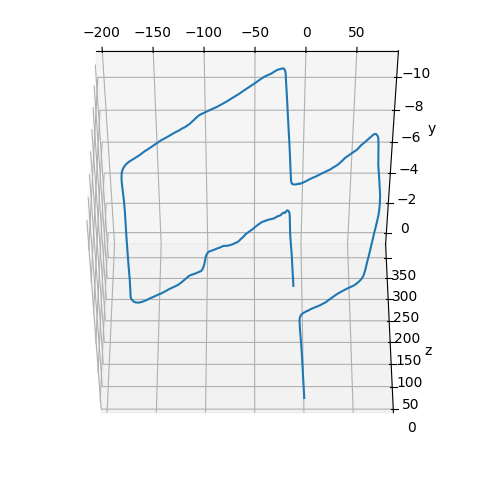

In [23]:
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(gt[:, :, 3][:, 0], gt[:, :, 3][:, 1], gt[:, :, 3][:, 2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(elev=-40, azim=270)

We can see that the trajectory starts and ends in the same spot, working around some corners, slanted on a bit of a hill.

Now let's take a quick look at our first image.

In [24]:
test_img = cv2.imread(f'/home/ros_ws/noetic/DeepVO/datasets/data_odometry_gray/dataset/sequences/{test_sequence}/image_0/000000.png')

In [25]:
type(test_img)

numpy.ndarray

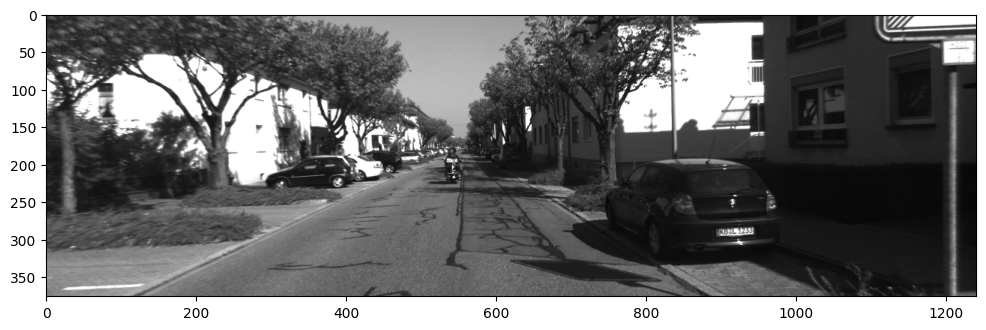

In [26]:
%matplotlib inline
plt.figure(figsize=(12,6))
plt.imshow(test_img)

## Data Exploration

In [27]:
# We can use the listdir() function to get a list of filenames in a folder
left_image_files = os.listdir(f'/home/ros_ws/noetic/DeepVO/datasets/data_odometry_gray/dataset/sequences/{test_sequence}/image_0')
left_image_files[:5]

['000505.png', '000919.png', '001403.png', '000294.png', '000973.png']

In [28]:
# We can use this list to count the number of images in the sequence
len(left_image_files)

1501

In [29]:
# Now we can check if this matches the number of ground truth posesa
len(poses)

1501

In [59]:
# We can see they match perfectly. Our first ground truth pose is (0, 0, 0), so we
# are tracking the motion of the camera with respect to the first camera frame.

In [30]:
times = pd.read_csv(f'/home/ros_ws/noetic/DeepVO/datasets/data_odometry_gray/dataset/sequences/{test_sequence}/times.txt', delimiter=' ', header=None)
times.head()

,0
0,0.000000
1,0.103736
2,0.207338
3,0.311075
4,0.414692


In [61]:
# We can see that the timing of the camera is right around 10fps

### Projection Matrices - Sensor Calibration

In [31]:
# We can load in our sensor calibration data as follows
calib = pd.read_csv('/home/ros_ws/noetic/DeepVO/datasets/data_odometry_calib/dataset/sequences/00/calib.txt', delimiter=' ', header=None, index_col=0)
calib

,1,2,3,4,5,6,7,8,9,10,11,12
0,,,,,,,,,,,,
P0:,718.856000,0.000000,607.192800,0.000000,0.000000,718.856000,185.215700,0.000000,0.000000,0.000000,1.000000,0.000000
P1:,718.856000,0.000000,607.192800,-386.144800,0.000000,718.856000,185.215700,0.000000,0.000000,0.000000,1.000000,0.000000
P2:,718.856000,0.000000,607.192800,45.382250,0.000000,718.856000,185.215700,-0.113089,0.000000,0.000000,1.000000,0.003780
P3:,718.856000,0.000000,607.192800,-337.287700,0.000000,718.856000,185.215700,2.369057,0.000000,0.000000,1.000000,0.004915
Tr:,0.000428,-0.999967,-0.008084,-0.011985,-0.007211,0.008081,-0.999941,-0.054040,0.999974,0.000486,-0.007207,-0.292197


We can see that they have provided us 3x4 projection matrices for 4 cameras, as well as the transformation matrix for the LIDAR labeled Tr. It is important to note that in the readme file for the dataset, these are the camera rectification matrices AFTER RECTIFICATION, which means that they are not normal rectification matrices. I will go into this more in just a moment.

*IMPORTANT NOTE*: If you DO NOT see a 5th row in the dataframe above labeled 'Tr', then, like me, your download did not come with a proper calibration file. This can be resolved by downloading the calibration file from [this link](http://www.cvlibs.net/download.php?file=data_odometry_calib.zip) and replacing the files in your dataset (use WinRAR to extract to the directory of your dataset and it will automatically merge the files into their correct locations). We won't be using LIDAR in this tutorial, so you can ignore this and keep following along, but you should have the right files for your own sake, and future tutorials will involve the LIDAR data.

In [32]:
# P0 is the projection matrix left grayscale camera
P0 = np.array(calib.loc['P0:']).reshape((3,4))
P0

array([[718.856 ,   0.    , 607.1928,   0.    ],
       [  0.    , 718.856 , 185.2157,   0.    ],
       [  0.    ,   0.    ,   1.    ,   0.    ]])

On the subject of projection matrices, let's take a moment to discuss what information is contained in these 3x4 matrices, and how it is useful to us. These matrices contain intrinsic information about the camera's focal length and optical center, which we will discuss later. Further, they also contain tranformation information which relates each camera's coordinate frame to the global coordinate frame (in this case that of the left grayscale camera).

A projection matrix takes 3D coordinates in the global coordinate frame and projects them onto the image plane of the camera through the following formula. Note that throughout this notebook, 3D coordinates in the global reference frame will have no subscript, and 3D coordinates in a camera's frame will be marked with subscript c.

![Projection Matrix](images/projection_matrix.png)

Notice that the left side of the equation is being multiplied by λ to be equivalent to the right side of the equation. This is known as the scale, and this is the depth to the point along the Z axis from the camera, that is, the Z value AFTER the transformation R|t has been applied to the 3D point to bring it into the camera's coordinate frame. Since we really want the homogeneous pixel coordinates (u, v, 1) that project the 3D point (X, Y, Z, 1), this equation may be more clearly written as:

![Projection Matrix 2](images/projection_matrix2.png)

We will return to talking about lambda (λ) in a moment. Let us first break down the relationship between a camera's projective matrix and its intrinsic and extrinsic matrices.

A projection matrix (P) is the dot product of the intrinsic and extrinsic matrices of a camera. The intrinsic matrix (k) contains the focal length and optical center parameters, and the extrinsic matrix (R|t) contains the pose of the camera in the same form we saw earlier with the ground truth poses of the car: a 3x3 rotation matrix horizontally stacked with a 3x1 translation vector. We can see the formula for P below:

![Projection Matrix Equation](images/P_matrix_eq.png)

Breaking down the P matrix into intrinsic and extrinsic camera matrices in the above equation then provides us with the following, which is a more explicit description of the process of projecting a 3D point in any coordinate frame into the pixel coordinate frame of the camera:

![Broken into Intrinsic and Extrinsic](images/intrinsic_extrinsic.png)

Now, remember that the projection matrices from the caibration file are the camera projection matrices for each camera AFTER RECTIFICATION in terms of the stereo rig. Normally, a camera's projection matrix take a 3D point in a global coordinate frame and projects it onto pixel coordinates on THAT camera's image frame. Rectified projection matrices are the opposite, and are designed to map points each camera's coordinate frame onto one single image plane: that of the left camera. This means they are going in the opposite direction, as these matrices are taking 3D points from the coordinate frame of the camera they are associated with, and projecting them onto the image plane of the left camera. If phrased in terms of normal projection matrix logic, P0 through P1 are basically 4 different projection matrices for the same (left grayscale) camera, considering 4 different "global" coordinate frames for each one of the cameras.

We can make a concrete example of the difference by considering the schematic of the sensor configuration provided by the KITTI team:

![KITTI Schematic](images/kitti_schematic.png)

We can see from the schematic that there are two stereo pairs of cameras, one set of grayscale and one set of RGB, and that the baseline (distance between right and left) is 0.54 meters on the X axis of the left grayscale camera.

If the projection matrices provided were standard per-camera projection matrices, we would expect the extrinsic matrix to take a point from the global coordinate frame and tranform it into the frame of the camera. For example, if we were to take the origin of the global coordinate frame (the origin of the left grayscale camera) and translate it into the coordinate frame of the right grayscale camera, we would expect to see an X coordinate of -0.54, since the left camera's origin is 0.54 meters to the left of the right grayscale camera's origin. To test this, we can decompose the projection matrix given for the right camera into k, R, and t though a useful function in OpenCV:

In [33]:
# Decomposing a projection matrix with OpenCV
P1 = np.array(calib.loc['P1:']).reshape((3,4))
k1, r1, t1, _, _, _, _ = cv2.decomposeProjectionMatrix(P1)
t1 = t1 / t1[3]
print('Intrinsic Matrix:')
print(k1)
print('Rotation Matrix:')
print(r1)
print('Translation Vector:')
print(t1.round(4))

Intrinsic Matrix:
[[718.856    0.     607.1928]
 [  0.     718.856  185.2157]
 [  0.       0.       1.    ]]
Rotation Matrix:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Translation Vector:
[[ 0.5372]
 [ 0.    ]
 [-0.    ]
 [ 1.    ]]


In [34]:
# Above, we can see the intrinsic matrix k, the rotation matrix R, and the translation vector
# t we got by decomposing the projection matrix given for the right camera. Remember that
# the extrinsic matrix is actually a horizontal stack of R and t in the form (R|t), which
# we can use to transform a 3D homogenous coordinate in the global frame to a 3D coordinate
# in the camera frame, at least if this were a normal camera projection matrix.
# In this case, let's see what we get if we transform the origin of the global coordinate
# frame (the origin of the left grayscale camera) using the tranformation/extrinsic matrix
# we got from this projection matrix. According to the schematic, we should expect it to be
# 0.54m to the left (X = -0.54)
# Note that the OpenCV function has provided t as a homogeneous coordinate, so we need to
# drop the fourth value to horizontally stack it with the 3x3 rotation matrix.
Rt = np.hstack([r1, t1[:3]])
# Now to consider transform the origin of the global frame (0, 0, 0, 1)
origin = np.array([0, 0, 0, 1])
Rt.dot(origin).round(4).reshape(-1,1)

array([[ 0.5372],
       [ 0.    ],
       [-0.    ]])

In [66]:
# And here we can see the issue: the X value is POSITIVE 0.54, which points 0.54m to the right
# of the camera frame, which tells us that this projection matrix is NOT actually referring to
# the right camera, it is referring to the left camera, and treating the origin of the right
# camera as the global coordinate frame. This is because it is a rectified projection matrix
# for a stereo rig, which is intended to project points from the coordinate frames of multiple
# cameras onto the SAME image plane, rather than the coordinates from one coordinate frame onto
# the image planes of multiple cameras.

Each rectified projection matrix will take (X, Y, Z, 1) homogeneous coordinates of 3D points in the associated sensor's coordinate frame and translates them to pixel locations (u, v, 1) on the image plane of the left grayscale camera.

Notice that the result we got from translating the origin is identical to the translation vector itself, so it is not necessary to do the extra step of math to figure out where the origin of the "global" coordinate frame is in relation to a camera, one only has to look at t. In this case, we can see that the rectified projection matrix decomposes into an extrinsic matrix which tells us that the "global" coordinate frame origin of the right camera is 0.54m to the right of the left camera, which matches what we see in the schematic.

In [35]:
# As an exercise, let's turn this rectified projection matrix into a regular projection matrix
# for the right grayscale camera. We do this by decomposing the matrix, making the extrinsic
# matrix homogeneous, inverting it, then recombining the intrinsic and inverted extrinsic.
# Since we've already decomposed and stacked the Rt transformation matrix, let's now make
# it homogeneous and run our test to see if the origin of the left camera appears at X=-0.54
T_homogeneous = np.vstack([Rt, np.array([0, 0, 0, 1])])
T_hom_inv = np.linalg.inv(T_homogeneous)
print('Homogeneous transformation matrix:')
print(T_homogeneous.round(4))
print('Inverted homogeneous transformation matrix:')
print(T_hom_inv.round(4))

Homogeneous transformation matrix:
[[ 1.      0.      0.      0.5372]
 [ 0.      1.      0.      0.    ]
 [ 0.      0.      1.     -0.    ]
 [ 0.      0.      0.      1.    ]]
Inverted homogeneous transformation matrix:
[[ 1.      0.      0.     -0.5372]
 [ 0.      1.      0.     -0.    ]
 [ 0.      0.      1.      0.    ]
 [ 0.      0.      0.      1.    ]]


In [68]:
# We can see that our t vector has indeed moved to -0.54
# If we want to have normal P matrices for each camera, this is the process we would follow
# This would come in handy if we were going to do visual odometry in the left and right 
# cameras simultaneously to smooth out noise. For now, we're just going to stick to one.

Now that we know what these calibration matrices are actually telling us, and that they are in all in reference to the left grayscale camera's image plane, let's go back and look again at the equation which projects 3D points form a given coordinate frame onto the image plane of a camera, and talk more about the lambda (λ) value. λ will have a single value when considering a single point transformation, or be a vector containing a separate value for each point if using the equation for matrices of multiple 3D points. Its value is equal to the Z value obtained AFTER the tranformation (R|t) has been applied to the 3D point, so the Z value of the point in the coordinate frame of the camera. This is the depth of the point from the camera. Because we are projecting 3D points onto a 2D surface, by dividing each point by its depth, we are projecting all of them onto a plane which is 1 unit away from the origin of the camera down the Z axis, since all points will subsequently have a Z value of 1 after the division. 

Note that the division by lambda in the right side of the equation can happen AT ANY POINT in the order of operations, that is, you could directly divide (X, Y, Z, 1) by it, then do the dot products, or divide the dot product of R|t and (X, Y, Z, 1) by it, then do the dot product with k, or do all the dot products and divide the result by it, and the result will be the same. Of course, the first option just listed doesn't make much sense, since we obtain the value of λ taking the dot product of R|t and (X, Y, Z, 1) and extracting the resulting Z coordinate in the camera frame, but nonetheless, we will do each computation now in python to prove the point.

In [36]:
# Let's take some point measured with respect to the coordinate frame of the left camera when 
# it is in it's 14 pose of the sequence, and transform it onto the image plane of the camera
# in it's first position, which we can do by using accessing the 14th pose from the ground truth
# Here are the coordinates of the point measured in this frame
some_point = np.array([1, 2, 3, 1]).reshape(-1,1)
# Let's get the depth of this point from the left camera by tranforming it into the coordinate
# frame of the left camera, and taking the Z value. We can do the transformation using the
# Rt matrix we stacked a moment ago.
transformed_point = gt[14].dot(some_point)
depth_from_cam = transformed_point[2]

print('Original point:\n', some_point)
print('Transformed point:\n', transformed_point.round(4))
print('Depth from camera:\n', depth_from_cam.round(4))

Original point:
 [[1]
 [2]
 [3]
 [1]]
Transformed point:
 [[ 0.2706]
 [ 1.5461]
 [15.0755]]
Depth from camera:
 [15.0755]


In [37]:
# To project this 3D point onto the image plane, we could first apply the intrinsic matrix, 
# THEN divide by the depth, which would take us from meters, to pixel*meters, then to pixels,
# or we could just divide by the depth first, taking us into unitless measurements by dividing
# meters by meters,then multiply by the intrinsic matrix, which would then take us from 
# unitless to pixels

# Multiplying by intrinsic matrix k, then dividing by depth
pixel_coordinates1 = k1.dot(transformed_point) / depth_from_cam

# Dividing by depth then multiplying by intrinsic matrix k
pixel_coordinates2 = k1.dot(transformed_point / depth_from_cam)

print('Pixel Coordinates 1st way:', pixel_coordinates1.T)
print('Pixel Coordinates 2nd way:', pixel_coordinates2.T)

Pixel Coordinates 1st way: [[620.09802465 258.93763336   1.        ]]
Pixel Coordinates 2nd way: [[620.09802465 258.93763336   1.        ]]


In [38]:
# We can see that we get the same results either way.
# Another thing that is done regularly is "normalizing" the pixel coordinates by multiplying
# them by the inverse of the intrinsic matrix k, which brings us back into unitless values,
# as we take pixel measurements and multiply them by the inverse of pixel measurements.
normalized_coordinates = np.linalg.inv(k1).dot(pixel_coordinates1)
print('Normalized Coordinates:', normalized_coordinates.T)

Normalized Coordinates: [[0.01795245 0.10255452 1.        ]]


In [39]:
# This is often done when using a series of points to estimate camera matrices, which we will
# not be doing, but it is important to know the reason why. Since the homogeneous pixel
# coordinates have large values representing the pixel positions, and have a small third
# componenet of 1, they can produce ill-conditioned matrices when using them to solve complex
# mathematical operations, so the normalized coordinates are used in these scenarios instead.
# For our purposes, it is interesting to see that if we take the normalized coordinates and
# multiply them by their respective depths, we can reconstruct the original 3D position from
# the 2D projection of a point (as long as we know the depth)
restored_3D = normalized_coordinates.T * depth_from_cam
restored_3D.round(4)

array([[ 0.2706,  1.5461, 15.0755]])

In [40]:
# And we are back to 3D coordinates in our camera frame.
# To get back to the 3D position in our original coordinate frame, we can add a row of
# (0, 0, 0, 1) to the transformation matrix we used to make it homogeneous, then invert it, 
# and finally dot it with the restored 3D coordinates in the camera frame (note that we
# also need to add a 1 to the end of these coordinates to make them homogeneous as well)
T_homogeneous = np.vstack([gt[14], np.array([0, 0, 0, 1])])
T_hom_inv = np.linalg.inv(T_homogeneous)
restored_3D_hom = np.append(restored_3D, 1)
T_hom_inv.dot(restored_3D_hom)

array([1., 2., 3., 1.])

In [74]:
# And there we have it, we went from a 3D point on a coordinate frame, projected it to pixel
# coordinates of a camera in a separate coordinate frame, reconstructed the metrics using a 
# known depth, and then reverse transformed the 3D point back into the original frame by
# inverting a homogeneous version of the original transformation matrix used and dotting it with
# the homogeneous 3D coordinates of the point in the camera's coordinate frame. This type of 
# math will come in handy later when we want to figure out where the car is in reference to the
# global coordinate frame.

What if we want to find the pixel coordinates of a 3D point located in the same frame as the camera? Recall that the first ground truth pose was an extrinsic matrix which was composed of an identity rotation matrix and a translation vector (0,0,0). Since an extrinsic matrix relates the pose of the camera to the global coordinate frame where (X, Y, Z, 1) are measured, and the first camera position IS the global coordinate frame, there is no transformation (rotation and tranlation) between them. Considering this alongside the above equations, we can see that if (X, Y, Z, 1) is measured in the camera's own coordinate frame, then the equation above becomes:

![Coordinate-to-Pixel](images/coordinate2pixel.png)

Recall that λ is the value of Z after 3D coordinates have been transformed (Z_c):

![Lambda = Z_c](images/lambdaequalsZ_c.png)

We can then rewrite the equation as follows to get to pixel coordinates:

![XYZ to Pixels](images/xyz2pixels.png)

Or we may wish to be in normalized (x, y, 1) coordinates by either not multiplying by k, or by dotting the inverse of k with (u, v, 1):

![XYZ to normalized](images/to_normalized.png)

Where (x_tilde, y_tilde, 1) are the normalized coordinates we discussed earlier, which represent the 3D points projected onto a 2D plane which is 1 unit (unitless) away from the origin of the camera down the Z axis. Let's take another look at the image we saw earlier to get an intuition for what this looks like.

![Camera Frame](images/camera_frame.png)

We can see that this picture depicts the image plane (x, y) and the pixel coordinate frame (u, v) together. Astute readers my see a difference from our concept of normalized coordinates here, however: the image plane is defined here as Z = f, meaning that the image plane is f (in meters) away from the camera origin. This is actually what you expect, since this is exactly what the focal length tells us about a pinhole camera: how far away from the aperture do the light rays converge to create a clear image. We can look at this old drawing of the first concept of a camera, the camera obscura, to get a very simple intuition for this:

![Camera Obscura](images/camera_obscura.jpg)

In this picture, the focal length is the distance between the wall with the hole and the wall with the image appearing. In modern camera modeling, we just flip this upside down image back around the origin back onto the positive Z axis, but it would still be on the plane Z = f. So how did we get to talking about a plane at Z = 1? For one thing, when we were talking about our normalized (x, y, 1) coordinates, we were unitless, so you might see where this is going: we've divided by the focal length in meters along the way. But where? I honestly had to do a lot of digging to figure this part out, but I'll explain it now.

First, let's look at a slide from Rober Collins of Penn State, and see that the coordinates on our image plane are derived using similar triangles and the focal length of the camera:

![Collins Similar Triangles](images/similar_triangles.png)

We can see that this projects the 3D coordinates onto a 2D surface which is the distance f (focal distance) from the origin of the camera, just like we expect when looking at the picture of the old timer above, where the image on the wall is f meters from the hole in the opposite wall. More concisely, we can write this projection like this:

![2D Projection](images/2d_projection.png)

We can see here that since the focal length f is in meters, and Z is in meters, the vector (X, Y, Z) (which is in meters) is being multiplied by a unitless ratio between focal distance and depth to point, so it maintains the unit of meters in the vector (x, y, f). This makes sense, since if the old timer above were to measure (x, y) coordinates of the image on the wall, he would be doing so in meters, and those measurements would be f meters from the pinhole, so they would all be at (x, y, f).

The secret is that the formula to calculate the 2D projection in pixel coordinates from a 3D coordinate in the same coordinate frame as the camera is actually as follows:

![True Formula](images/true_formula.png)

Where we can see that we cancel out the focal length multiplication with the projection on the right side. How is it that we're getting away with multiplying only one side by 1/f? The answer is that the intrinsic matrix actually contains f, but measured in pixels. The contents of the intrinsic matrix are as follows:

![Intrinsic Matrix](images/intrinsic_matrix.png)

So we see then that we are still multiplying x and y by f, but not z. Why not? It seems there are two reasons: 1) Nobody cares how far a point in a 2D image is in pixels away from the origin of the camera, the information is not useful; and 2) By keeping the third value of (u, v, 1) a 1, we have a happy set of 2D homogeneous coordinates which make math easier. The short answer is, we simply threw away the information about the depth to the image plane because it tells us nothing about anything. Once we divided by λ, we lost all useful depth information about our 3D point(s), and this cannot be retrieved without finding it some other way. This is where the stereo rig steps in!

The remaining two values in the intrinsic matrix, c_x and c_y, represent the optical center of the image, that is, where rays of light coming directly down the Z axis of the camera coordinate frame will intersect the pixel plane. While one might want to assume that this would be at the center of the camera's sensor, it is often the case that the sensor is slightly off of center with the lens, so this adjustment in the intrinsic matrix ensures that we are mapping incoming light rays to the proper pixel coordinate they will be at when they hit the camera sensor.

In [41]:
# Let's compare the optical center to the size of the image (expect it to be halfway?)
test_img.shape

(376, 1241, 3)

In [42]:
cx = k1[0,2]
cy = k1[1,2]
print('Actual center of image (x, y):', (test_img.shape[1]/2, test_img.shape[0]/2))
print('Optical center of image (cx, cy)', (cx, cy))

Actual center of image (x, y): (620.5, 188.0)
Optical center of image (cx, cy) (np.float64(607.1928), np.float64(185.2157))


In [77]:
# We can see that the optical center of the camera is very close, but not quite, the center of
# the image itself. This is why camera calibration information is important, because if we had
# assumed that light coming down the camera's Z axis hit the center of the image plane, we 
# would have been projecting points in the world to the wrong parts of the image.

It is useful to take a moment to look at how c_x and c_y affect the math. They are added to the result of multiplying x or y with their respective focal length in pixels to shift the origin of the pixel plane to the upper left corner, as pixels are counted from there. Below is an explicit description of how pixel coordinates are calculated from 3D coordinates which are in the camera's frame.

![Pixel Calculation](images/pixel_calculation.png)

To finish up our data exploration, let's look at the other two camera matrices included in our calibration file, which refer to the RGB cameras in the rig.

In [43]:
# The next two matrices are referring to the RGB cameras. In that case we won't
# need them, but let's see if this makes sense
P2 = np.array(calib.loc['P2:']).reshape((3,4))
k2, r2, t2, _, _, _, _ = cv2.decomposeProjectionMatrix(P2)
t2 = t2 / t2[3]
print(k2)
print(r2)
print(t2)

[[718.856    0.     607.1928]
 [  0.     718.856  185.2157]
 [  0.       0.       1.    ]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[-0.05993858]
 [ 0.00113119]
 [-0.00377976]
 [ 1.        ]]


In [44]:
# We can see that this camera is just slightly to the left of the main camera.
# Let's now repeat this process for the fourth P matrix and see what we see
P3 = np.array(calib.loc['P3:']).reshape((3,4))
k3, r3, t3, _, _, _, _ = cv2.decomposeProjectionMatrix(P3)
t3 = t3 / t3[3]
print(k3)
print(r3)
print(t3)

[[718.856    0.     607.1928]
 [  0.     718.856  185.2157]
 [  0.       0.       1.    ]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[ 0.47335236]
 [-0.00202917]
 [-0.00491521]
 [ 1.        ]]


Hopefully I have not lost you with all of this theoretical review, but it really helps to have a full intuitive understanding of these concepts as we move forward with out stereo depth estimation and visual odometry project here.

### Dataset Handling
Let's make a dataset handling object to make our data more accessible as we complete our task.

*NOTE:* It is extremely important to exlicitly tell numpy to decode the velodyne binaries as float32, because it defaults to float64 and will therefore decode the information incorrectly.

In [ ]:
class Dataset_Handler():
    def __init__(self, sequence, lidar=False, progress_bar=True, low_memory=True):
        import pandas as pd
        import os
        import cv2
        
        # This will tell our odometry function if handler contains lidar info
        self.lidar = lidar
        # This will tell odometry functin how to access data from this object
        self.low_memory = low_memory
        
        # Set file paths and get ground truth poses
        self.seq_dir = '/home/ros_ws/noetic/DeepVO/datasets/data_odometry_gray/dataset/sequences/{}/'.format(sequence)
        self.poses_dir = '/home/ros_ws/noetic/DeepVO/datasets/data_odometry_gray/dataset/data_odometry_poses/dataset/{}.txt'.format(sequence)
        poses = pd.read_csv(self.poses_dir, delimiter=' ', header=None)
        
        # Get sorted names of files to iterate through
        self.left_image_files = sorted(os.listdir(self.seq_dir + 'image_0'), key=lambda x: int(x.split(".")[0]))
        self.right_image_files = sorted(os.listdir(self.seq_dir + 'image_1'), key=lambda x: int(x.split(".")[0]))
        self.num_frames = len(self.left_image_files)
        self.calib_dir = '/home/ros_ws/noetic/DeepVO/datasets/data_odometry_calib/dataset/sequences/{}/'.format(sequence)

        if self.lidar:
            self.lidar_path = self.seq_dir + 'velodyne/'
            self.velodyne_files = os.listdir(self.seq_dir + 'velodyne')
        
        # Get calibration details for scene
        # P0 and P1 are Grayscale cams, P2 and P3 are RGB cams
        calib = pd.read_csv(self.calib_dir + 'calib.txt', delimiter=' ', header=None, index_col=0)
        self.P0 = np.array(calib.loc['P0:']).reshape((3,4))
        self.P1 = np.array(calib.loc['P1:']).reshape((3,4))
        self.P2 = np.array(calib.loc['P2:']).reshape((3,4))
        self.P3 = np.array(calib.loc['P3:']).reshape((3,4))
        # This is the transformation matrix for LIDAR
        self.Tr = np.array(calib.loc['Tr:']).reshape((3,4))
        
        # Get times and ground truth poses
        self.times = np.array(pd.read_csv(self.seq_dir + 'times.txt', 
                                          delimiter=' ', 
                                          header=None))
        self.gt = np.zeros((len(poses), 3, 4))
        for i in range(len(poses)):
            self.gt[i] = np.array(poses.iloc[i]).reshape((3, 4))
        
        # Get images and lidar loaded
        if self.low_memory:
            # Will use generators to provide data sequentially to save RAM
            # Use class method to set up generators
            self.reset_frames()
            # Store original frame to memory for testing functions
            self.first_image_left = cv2.imread(self.seq_dir + 'image_0/' 
                                               + self.left_image_files[0], 0)
            self.first_image_right = cv2.imread(self.seq_dir + 'image_1/' 
                                               + self.right_image_files[0], 0)
            self.second_image_left = cv2.imread(self.seq_dir + 'image_0/' 
                                               + self.left_image_files[1], 0)
            if self.lidar:
                self.first_pointcloud = np.fromfile(self.lidar_path + self.velodyne_files[0],
                                                    dtype=np.float32, 
                                                    count=-1).reshape((-1, 4))
            self.imheight = self.first_image_left.shape[0]
            self.imwidth = self.first_image_left.shape[1]
            
        else:
            # If RAM is not a concern (>32GB), pass low_memory=False
            if progress_bar:
                import progressbar
                bar = progressbar.ProgressBar(max_value=self.num_frames)
            self.images_left = []
            self.images_right = []
            self.pointclouds = []
            for i, name_left in enumerate(self.left_image_files):
                name_right = self.right_image_files[i]
                self.images_left.append(cv2.imread(self.seq_dir + 'image_0/' + name_left))
                self.images_right.append(cv2.imread(self.seq_dir + 'image_1/' + name_right))
                if self.lidar:
                    pointcloud = np.fromfile(self.lidar_path + self.velodyne_files[i], 
                                             dtype=np.float32, 
                                             count=-1).reshape([-1,4])
                    self.pointclouds.append(pointcloud)
                if progress_bar:
                    bar.update(i+1)
                
            self.imheight = self.images_left[0].shape[0]
            self.imwidth = self.images_left[0].shape[1]
            # Keep consistent instance variable names as when using low_memory
            self.first_image_left = self.images_left[0]
            self.first_image_right = self.images_right[0]
            self.second_image_left = self.images_left[1]
            if self.lidar:
                self.first_pointcloud = self.pointclouds[0]
            
    def reset_frames(self):
        # Resets all generators to the first frame of the sequence
        self.images_left = (cv2.imread(self.seq_dir + 'image_0/' + name_left, 0)
                            for name_left in self.left_image_files)
        self.images_right = (cv2.imread(self.seq_dir + 'image_1/' + name_right, 0)
                            for name_right in self.right_image_files)
        if self.lidar:
            self.pointclouds = (np.fromfile(self.lidar_path + velodyne_file, 
                                            dtype=np.float32, 
                                            count=-1).reshape((-1, 4))
                                for velodyne_file in self.velodyne_files)
        pass

In [81]:
# Create a handler for machines using plenty of RAM (>32GB). Do not run this cell if you have
# less than 32GB of RAM
#handler2 = Dataset_Handler('00', low_memory=False)

In [49]:
# Creating a handler object for low_memory (<32GB) setups:
handler = Dataset_Handler(f'{test_sequence}')

# Stereo Depth + Visual Odometry
In this section, I will attempt to track the pose of the vehicle using depth maps derived from stereopsis, then using visual odometry of the left camera to track motion at scale.

To review the essentials of the math behind stereo depth, we can view the following diagram of a stereo pair observing a single point O:

![Stereo Camera Diagram](images/stereo_camera.png)

Using similar triangles, we can write the following:

![Stereo Formulas 1](images/stereo_formulas1.png)

We now define disparity, d, as the difference between x_L and x_R, meaning the difference in horizontal pixel location of the point projected onto the left and right image planes.

![Disparity Formula](images/disparity_formula.png)

Rearranging the above similar triangles equations, we can get:

![Stereo Formulas 2](images/stereo_formulas2.png)

Substituing Z * x_L into f * X in the second equation, we get:

![Stereo Formulas 3](images/stereo_formulas3.png)

Which can be rewritten as:

![Stereo Formulas 4](images/stereo_formulas4.png)

Then we can substitute d in from our definition of disparity, and solve for Z:

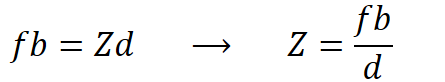

Note that if the focal length and disparity are measured in pixels, then the pixel units will cancel, and if we have our baseline measured in meters, then our Z measurement will be in meters, which is desirable for reconstructing 3D coordinates later.

We now have a simple way to compute depth from our stereo pair of images if we have our baseline (found earlier to be 0.54m by comparing the camera extrinsic matrices), focal length of x direction in pixels (found earlier to be 718.856px from the camera intrinsic matrix), and disparity between the same points between the two images.

In order to find this third necessary ingredient, we can use the stereo matching objects available in OpenCV: either StereoBM or StereoSGBM. As we will see, StereoBM is faster, but StereoSGBM produces better results.

In [50]:
def compute_left_disparity_map(img_left, img_right, matcher='bm', rgb=False, verbose=False):
    '''
    Takes a left and right stereo pair of images and computes the disparity map for the left
    image. Pass rgb=True if the images are RGB.
    
    Arguments:
    img_left -- image from left camera
    img_right -- image from right camera
    
    Optional Arguments:
    matcher -- (str) can be 'bm' for StereoBM or 'sgbm' for StereoSGBM matching
    rgb -- (bool) set to True if passing RGB images as input
    verbose -- (bool) set to True to report matching type and time to compute
    
    Returns:
    disp_left -- disparity map for the left camera image
    
    '''
    # Feel free to read OpenCV documentation and tweak these values. These work well
    sad_window = 6
    num_disparities = sad_window*16
    block_size = 11
    matcher_name = matcher
    
    if matcher_name == 'bm':
        matcher = cv2.StereoBM_create(numDisparities=num_disparities,
                                      blockSize=block_size
                                     )
        
    elif matcher_name == 'sgbm':
        matcher = cv2.StereoSGBM_create(numDisparities=num_disparities,
                                        minDisparity=0,
                                        blockSize=block_size,
                                        P1 = 8 * 3 * sad_window ** 2,
                                        P2 = 32 * 3 * sad_window ** 2,
                                        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
                                       )
    if rgb:
        img_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
        img_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)
    start = datetime.datetime.now()
    disp_left = matcher.compute(img_left, img_right).astype(np.float32)/16
    end = datetime.datetime.now()
    if verbose:
        print(f'Time to compute disparity map using Stereo{matcher_name.upper()}:', end-start)
    
    return disp_left

In [84]:
%matplotlib inline

Time to compute disparity map using StereoBM: 0:00:00.012908


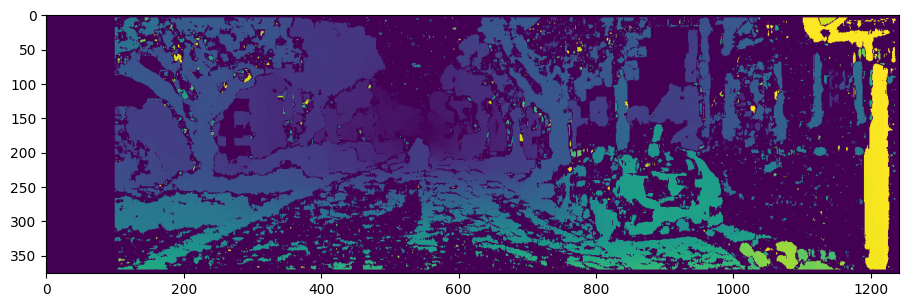

In [51]:
# Compute disparity using StereoBM
disp = compute_left_disparity_map(handler.first_image_left, 
                                  handler.first_image_right, 
                                  matcher='bm',
                                  verbose=True)
plt.figure(figsize=(11,7))
plt.imshow(disp);

Time to compute disparity map using StereoSGBM: 0:00:00.039090


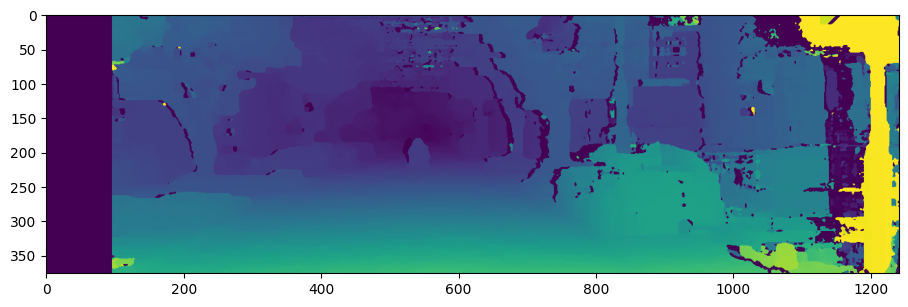

In [52]:
# Now to compare this to StereoSGBM
disp = compute_left_disparity_map(handler.first_image_left, 
                                  handler.first_image_right, 
                                  matcher='sgbm',
                                  verbose=True)
plt.figure(figsize=(11,7))
plt.imshow(disp);

In [87]:
# We can see that StereoSGBM takes around 3x as long, but produces a much more contiguous
# disparity map, with less gaps in information

We can see that there is a gap of the left side of the image where the right camera did not have matching information. This means that we should apply a mask when looking for features to match from one frame to the next so that we can use features which fall in the area of the picture for which we have depth information.

In [53]:
# A look at what value the function above produces in places where it gets improper/missing data
disp[0,0]

np.float32(-1.0)

In [55]:
def decompose_projection_matrix(p):
    '''
    Shortcut to use cv2.decomposeProjectionMatrix(), which only returns k, r, t, and divides
    t by the scale, then returns it as a vector with shape (3,) (non-homogeneous)
    
    Arguments:
    p -- projection matrix to be decomposed
    
    Returns:
    k, r, t -- intrinsic matrix, rotation matrix, and 3D translation vector
    
    '''
    k, r, t, _, _, _, _ = cv2.decomposeProjectionMatrix(p)
    t = (t / t[3])[:3]
    
    return k, r, t

def calc_depth_map(disp_left, k_left, t_left, t_right, rectified=True):
    '''
    Calculate depth map using a disparity map, intrinsic camera matrix, and translation vectors
    from camera extrinsic matrices (to calculate baseline). Note that default behavior is for
    rectified projection matrix for right camera. If using a regular projection matrix, pass
    rectified=False to avoid issues.
    
    Arguments:
    disp_left -- disparity map of left camera
    k_left -- intrinsic matrix for left camera
    t_left -- translation vector for left camera
    t_right -- translation vector for right camera
    
    Optional Arguments:
    rectified -- (bool) set to False if t_right is not from rectified projection matrix
    
    Returns:
    depth_map -- calculated depth map for left camera
    
    '''
    # Get focal length of x axis for left camera
    f = k_left[0][0]
    
    # Calculate baseline of stereo pair
    if rectified:
        b = t_right[0] - t_left[0] 
    else:
        b = t_left[0] - t_right[0]
        
    # Avoid instability and division by zero
    disp_left[disp_left == 0.0] = 0.1
    disp_left[disp_left == -1.0] = 0.1
    
    # Make empty depth map then fill with depth
    depth_map = np.ones(disp_left.shape)
    depth_map = f * b / disp_left
    
    return depth_map

In [56]:
k_left, r_left, t_left = decompose_projection_matrix(handler.P0)
k_right, r_right, t_right = decompose_projection_matrix(handler.P1)

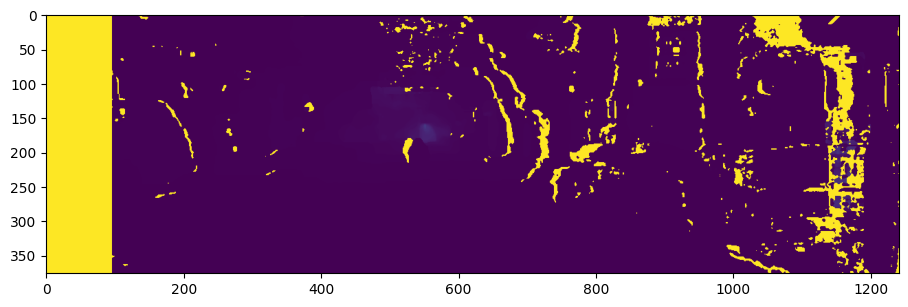

In [57]:
depth = calc_depth_map(disp, k_left, t_left, t_right)
plt.figure(figsize=(11,7))
plt.imshow(depth);

In [58]:
# Let's see what the depth is in the yellow band to the left
depth[0,0]

np.float64(3861.4479424599417)

In [59]:
# Let's see if this is the same as the maximum estimated depth
depth.max()

np.float64(3861.4479424599417)

In [60]:
# Knowing the focal length and baseline, we can see that these max values are the result of
# wherever we had -1.0 or 0 disparity, which we turned to 0.1 in the depth map function to
# avoid instability or division by zero, shown below:
k_left[0][0] * (t_right[0] - t_left[0]) / 0.1

array([3861.448])

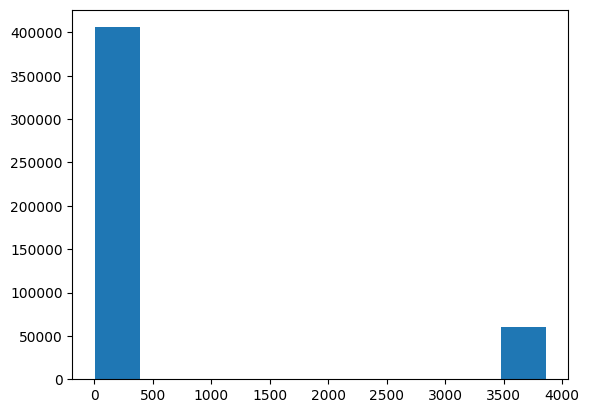

In [61]:
# We do not want any features found at this depth to enter into our calculations, since
# this is just a filler value and is not a valid estimation of depth. We need to pick a depth
# at which to filter our depth estimations.
# Let's see the distribution of depths from our depth map, so we can decide a threshold to cut
# off points of consideration so they don't mess with our geometry
plt.hist(depth.flatten());

In [96]:
# We can see that there is a big gap between our real depth values and the erroneous max depth
# where the stereo depth computation failed. This means that we can pick a depth of 3000 to
# filter out any points that we consider in our feature matching, to make sure that we are
# matching features that are within a reasonable distance from us that we have real depth
# estimations for.

In [62]:
# We want to find the width of the yellow band, in order to
# create a mask to prevent the feature detector from searching in a useless area for features
# on every frame, which would waste time.
for i, pixel in enumerate(depth[4]):
    if pixel < depth.max():
        print('First non-max value at index', i)
        break

First non-max value at index 96


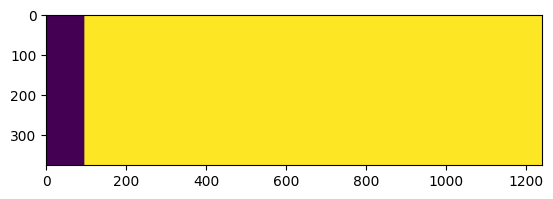

In [63]:
# We can constuct a mask using this information like so
mask = np.zeros(handler.first_image_left.shape[:2], dtype=np.uint8)
ymax = handler.first_image_left.shape[0]
xmax = handler.first_image_left.shape[1]
cv2.rectangle(mask, (96,0), (xmax,ymax), (255), thickness = -1)
plt.imshow(mask);

In [64]:
# Let's make an all-inclusive function to get the depth from an incoming set of stereo images
def stereo_2_depth(img_left, img_right, P0, P1, matcher='bm', rgb=False, verbose=False, 
                   rectified=True):
    '''
    Takes stereo pair of images and returns a depth map for the left camera. If your projection
    matrices are not rectified, set rectified=False.
    
    Arguments:
    img_left -- image of left camera
    img_right -- image of right camera
    P0 -- Projection matrix for the left camera
    P1 -- Projection matrix for the right camera
    
    Optional Arguments:
    matcher -- (str) can be 'bm' for StereoBM or 'sgbm' for StereoSGBM
    rgb -- (bool) set to True if images passed are RGB. Default is False
    verbose -- (bool) set to True to report computation time and method
    rectified -- (bool) set to False if P1 not rectified to P0. Default is True
    
    Returns:
    depth -- depth map for left camera
    
    '''
    # Compute disparity map
    disp = compute_left_disparity_map(img_left, 
                                      img_right, 
                                      matcher=matcher, 
                                      rgb=rgb, 
                                      verbose=verbose)
    # Decompose projection matrices
    k_left, r_left, t_left = decompose_projection_matrix(P0)
    k_right, r_right, t_right = decompose_projection_matrix(P1)
    # Calculate depth map for left camera
    depth = calc_depth_map(disp, k_left, t_left, t_right)
    
    return depth

## Extracting and Matching Features
Now that we have a way to get our stereo depth estimations, we need to make some helper functions for detecting and matching features between two images. These functions are found below. We will mainly use David Lowe's [SIFT](https://people.eecs.berkeley.edu/~malik/cs294/lowe-ijcv04.pdf) in this tutorial, since it is a classic, robust approach that computes scale and rotation invariant feature descriptors. For more details, refer to the OpenCV [Introduction to SIFT](https://docs.opencv.org/master/da/df5/tutorial_py_sift_intro.html) article.

In [65]:
def extract_features(image, detector='sift', mask=None):
    """
    Find keypoints and descriptors for the image

    Arguments:
    image -- a grayscale image

    Returns:
    kp -- list of the extracted keypoints (features) in an image
    des -- list of the keypoint descriptors in an image
    """
    if detector == 'sift':
        det = cv2.SIFT_create()
    elif detector == 'orb':
        det = cv2.ORB_create()
    elif detector == 'surf':
        det = cv2.xfeatures2d.SURF_create()
        
    kp, des = det.detectAndCompute(image, mask)
    
    return kp, des

In [66]:
def match_features(des1, des2, matching='BF', detector='sift', sort=True, k=2):
    """
    Match features from two images

    Arguments:
    des1 -- list of the keypoint descriptors in the first image
    des2 -- list of the keypoint descriptors in the second image
    matching -- (str) can be 'BF' for Brute Force or 'FLANN'
    detector -- (str) can be 'sift or 'orb'. Default is 'sift'
    sort -- (bool) whether to sort matches by distance. Default is True
    k -- (int) number of neighbors to match to each feature.

    Returns:
    matches -- list of matched features from two images. Each match[i] is k or less matches for 
               the same query descriptor
    """
    if matching == 'BF':
        if detector == 'sift':
            matcher = cv2.BFMatcher_create(cv2.NORM_L2, crossCheck=False)
        elif detector == 'orb':
            matcher = cv2.BFMatcher_create(cv2.NORM_HAMMING2, crossCheck=False)
        matches = matcher.knnMatch(des1, des2, k=k)
    elif matching == 'FLANN':
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)
        matcher = cv2.FlannBasedMatcher(index_params, search_params)
        matches = matcher.knnMatch(des1, des2, k=k)
    
    if sort:
        matches = sorted(matches, key = lambda x:x[0].distance)

    return matches

### Filtering Matches based on Distance Ratios
The creator of SIFT, David Lowe, [also proposed a ratio test](https://people.eecs.berkeley.edu/~malik/cs294/lowe-ijcv04.pdf) to determine the level of distinctiveness of features. This test involves finding the two nearest neighbors in the second image to the descriptor of each feature in the first, then using the ratio of their distances from their matched feature to see whether the distance between that feature's descriptor and its closest match is significantly different than the distance to its second closest match. If it is not, then this implies that the feature is not highly distinct, since it is roughly equally similar to at least two features in the second image, and should therefore not be used for photogrammetric reconstruction of motion.

We can see an informative graphic relating the quality of matches according to this metric below:

![Lowe Ratio Test](images/lowe_ratio_test.png)

(Image courtesy of [OpenCV Docs](https://docs.opencv.org/3.4/d5/d6f/tutorial_feature_flann_matcher.html))

We can see that there is a sweet spot found for this ratio between 0.4 and 0.5, meaning that we want the distance to the closest match to be about half the distance to the second closest match in order to be certain that the feature is distinct, and not too similar to multiple features in the second image.

In [67]:
def filter_matches_distance(matches, dist_threshold):
    """
    Filter matched features from two images by distance between the best matches

    Arguments:
    match -- list of matched features from two images
    dist_threshold -- maximum allowed relative distance between the best matches, (0.0, 1.0) 

    Returns:
    filtered_match -- list of good matches, satisfying the distance threshold
    """
    filtered_match = []
    for m, n in matches:
        if m.distance <= dist_threshold*n.distance:
            filtered_match.append(m)

    return filtered_match

In [68]:
def visualize_matches(image1, kp1, image2, kp2, match):
    """
    Visualize corresponding matches in two images

    Arguments:
    image1 -- the first image in a matched image pair
    kp1 -- list of the keypoints in the first image
    image2 -- the second image in a matched image pair
    kp2 -- list of the keypoints in the second image
    match -- list of matched features from the pair of images

    Returns:
    image_matches -- an image showing the corresponding matches on both image1 and image2 or None if you don't use this function
    """
    image_matches = cv2.drawMatches(image1, kp1, image2, kp2, match, None, flags=2)
    plt.figure(figsize=(16, 6), dpi=100)
    plt.imshow(image_matches)

Time to compute disparity map using StereoSGBM: 0:00:00.038458
Number of matches before filtering: 3206
Number of matches after filtering: 446


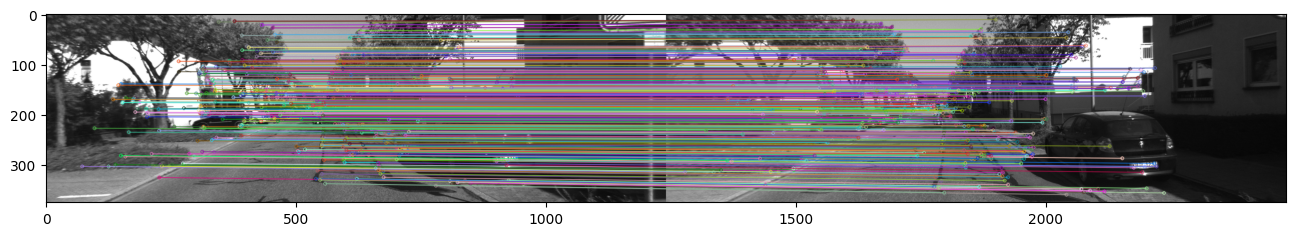

In [69]:
# Look at matched points using sgbm matcher
image_left = handler.first_image_left
image_right = handler.first_image_right
image_plus1 = handler.second_image_left
depth = stereo_2_depth(image_left, 
                       image_right, 
                       handler.P0, 
                       handler.P1,
                       matcher='sgbm',
                       verbose=True)
kp0, des0 = extract_features(image_left, 'sift')
kp1, des1 = extract_features(image_plus1, 'sift')
matches = match_features(des0, des1, matching='BF', detector='sift', sort=True)
print('Number of matches before filtering:', len(matches))
matches = filter_matches_distance(matches, 0.3)
print('Number of matches after filtering:', len(matches))
visualize_matches(image_left, kp0, image_plus1, kp1, matches)

Time to compute disparity map using StereoBM: 0:00:00.013657
Number of matches before filtering: 3206
Number of matches after filtering: 446


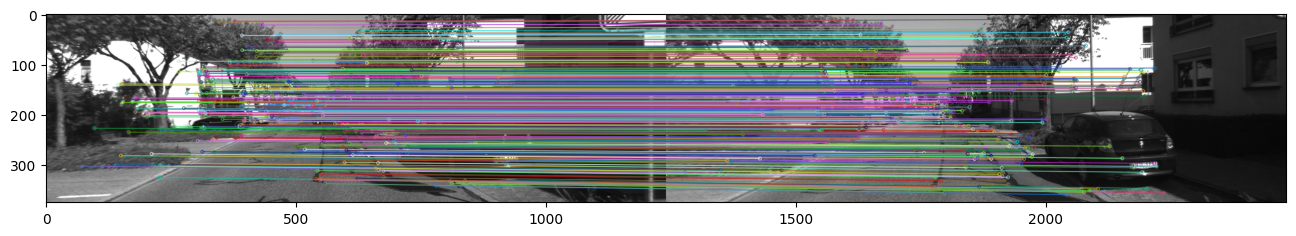

In [70]:
# Now to see the difference with 'bm' matcher
image_left = handler.first_image_left
image_right = handler.first_image_right
image_plus1 = handler.second_image_left
depth = stereo_2_depth(image_left, 
                       image_right, 
                       handler.P0, 
                       handler.P1,
                       matcher='bm',
                       verbose=True)
kp0, des0 = extract_features(image_left, 'sift')
kp1, des1 = extract_features(image_plus1, 'sift')
matches = match_features(des0, des1, matching='BF', detector='sift', sort=True)
print('Number of matches before filtering:', len(matches))
matches = filter_matches_distance(matches, 0.3)
print('Number of matches after filtering:', len(matches))
visualize_matches(image_left, kp0, image_plus1, kp1, matches)

In [106]:
# We can see that the 'bm' matcher is around 5x faster than the 'sgbm' matcher, and produced the
# same number of matches. Since speed is essential, we will use the 'bm' matcher

Time to compute disparity map using StereoBM: 0:00:00.020424
Number of matches before filtering: 500
Number of matches after filtering: 260


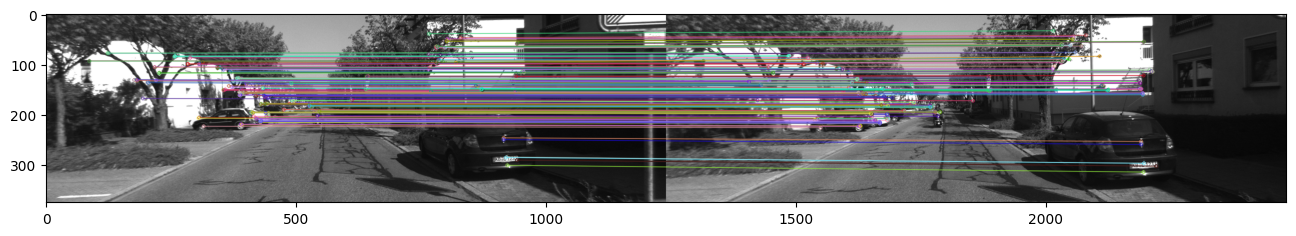

In [71]:
# Now to see the difference with ORB descriptor
image_left = handler.first_image_left
image_right = handler.first_image_right
image_plus1 = handler.second_image_left
depth = stereo_2_depth(image_left, 
                       image_right, 
                       handler.P0, 
                       handler.P1,
                       matcher='bm',
                       verbose=True)
kp0, des0 = extract_features(image_left, 'orb')
kp1, des1 = extract_features(image_plus1, 'orb')
matches = match_features(des0, des1, matching='BF', detector='orb', sort=True)
print('Number of matches before filtering:', len(matches))
matches = filter_matches_distance(matches, 0.8)
print('Number of matches after filtering:', len(matches))
visualize_matches(image_left, kp0, image_plus1, kp1, matches)

In [72]:
def pointcloud2image(pointcloud, imheight, imwidth, Tr, P0):
    '''
    Takes a pointcloud of shape Nx4 and projects it onto an image plane, first transforming
    the X, Y, Z coordinates of points to the camera frame with tranformation matrix Tr, then
    projecting them using camera projection matrix P0.
    
    Arguments:
    pointcloud -- array of shape Nx4 containing (X, Y, Z, reflectivity)
    imheight -- height (in pixels) of image plane
    imwidth -- width (in pixels) of image plane
    Tr -- 3x4 transformation matrix between lidar (X, Y, Z, 1) homogeneous and camera (X, Y, Z)
    P0 -- projection matrix of camera (should have identity transformation if Tr used)
    
    Returns:
    render -- a (imheight x imwidth) array containing depth (Z) information from lidar scan
    
    '''
    # We know the lidar X axis points forward, we need nothing behind the lidar, so we
    # ignore anything with a X value less than or equal to zero
    pointcloud = pointcloud[pointcloud[:, 0] > 0]
    
    # We do not need reflectance info, so drop last column and replace with ones to make
    # coordinates homogeneous for tranformation into the camera coordinate frame
    pointcloud = np.hstack([pointcloud[:, :3], np.ones(pointcloud.shape[0]).reshape((-1,1))])
    
    # Transform pointcloud into camera coordinate frame
    cam_xyz = Tr.dot(pointcloud.T)
    
    # Ignore any points behind the camera (probably redundant but just in case)
    cam_xyz = cam_xyz[:, cam_xyz[2] > 0]
    
    # Extract the Z row which is the depth from camera
    depth = cam_xyz[2].copy()
    
    # Project coordinates in camera frame to flat plane at Z=1 by dividing by Z
    cam_xyz /= cam_xyz[2]
    
    # Add row of ones to make our 3D coordinates on plane homogeneous for dotting with P0
    cam_xyz = np.vstack([cam_xyz, np.ones(cam_xyz.shape[1])])
    
    # Get pixel coordinates of X, Y, Z points in camera coordinate frame
    projection = P0.dot(cam_xyz)
    #projection = (projection / projection[2])
    
    # Turn pixels into integers for indexing
    pixel_coordinates = np.round(projection.T, 0)[:, :2].astype('int')
    #pixel_coordinates = np.array(pixel_coordinates)
    
    # Limit pixel coordinates considered to those that fit on the image plane
    indices = np.where((pixel_coordinates[:, 0] < imwidth)
                       & (pixel_coordinates[:, 0] >= 0)
                       & (pixel_coordinates[:, 1] < imheight)
                       & (pixel_coordinates[:, 1] >= 0)
                      )
    pixel_coordinates = pixel_coordinates[indices]
    depth = depth[indices]
    
    # Establish empty render image, then fill with the depths of each point
    render = np.zeros((imheight, imwidth))
    for j, (u, v) in enumerate(pixel_coordinates):
        if u >= imwidth or u < 0:
            continue
        if v >= imheight or v < 0:
            continue
        render[v, u] = depth[j]
    # Fill zero values with large distance so they will be ignored. (Using same max value)
    render[render == 0.0] = 3861.45
    
    return render

Time to compute disparity map using StereoSGBM: 0:00:00.052599


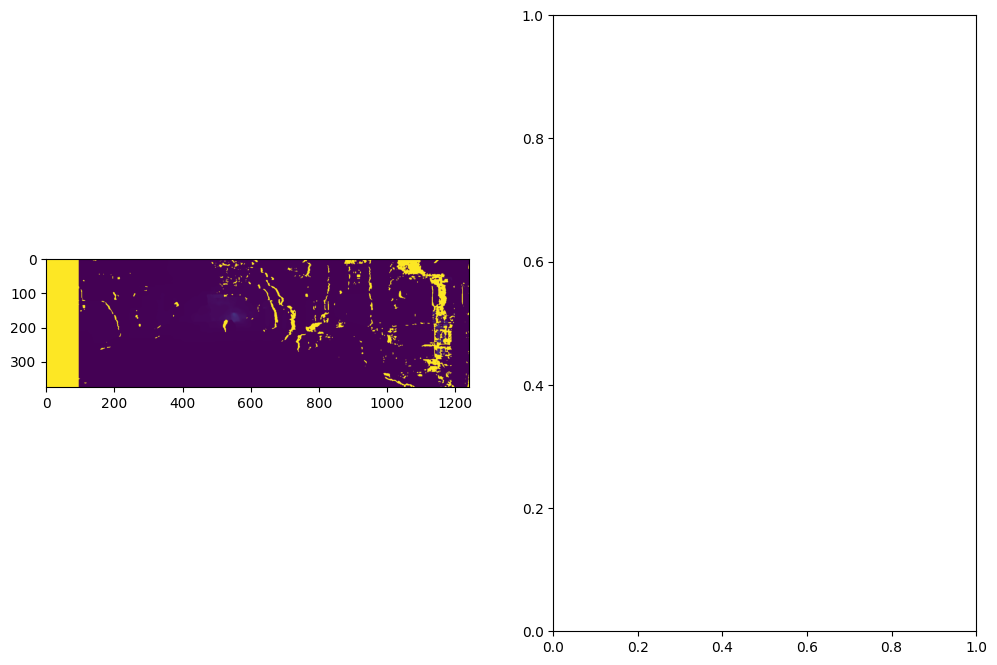

In [112]:
# Now a side-by-side comparison of the stereo depth vs lidar depth maps
depth_stereo = stereo_2_depth(image_left, 
                             image_right, 
                             handler.P0, 
                             handler.P1,
                             matcher='sgbm',
                             verbose=True)
#depth_lidar = pointcloud2image(handler.first_pointcloud, handler.imheight, handler.imwidth,
                               #handler.Tr, handler.P0
                              #)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,8))
ax1.imshow(depth_stereo)
#ax2.imshow(depth_lidar)

In [73]:
def estimate_motion(match, kp1, kp2, k, depth1=None, max_depth=3000):
    """
    Estimate camera motion from a pair of subsequent image frames

    Arguments:
    match -- list of matched features from the pair of images
    kp1 -- list of the keypoints in the first image
    kp2 -- list of the keypoints in the second image
    k -- camera intrinsic calibration matrix 
    
    Optional arguments:
    depth1 -- Depth map of the first frame. Set to None to use Essential Matrix decomposition
    max_depth -- Threshold of depth to ignore matched features. 3000 is default

    Returns:
    rmat -- estimated 3x3 rotation matrix
    tvec -- estimated 3x1 translation vector
    image1_points -- matched feature pixel coordinates in the first image. 
                     image1_points[i] = [u, v] -> pixel coordinates of i-th match
    image2_points -- matched feature pixel coordinates in the second image. 
                     image2_points[i] = [u, v] -> pixel coordinates of i-th match
               
    """
    rmat = np.eye(3)
    tvec = np.zeros((3, 1))
    
    image1_points = np.float32([kp1[m.queryIdx].pt for m in match])
    image2_points = np.float32([kp2[m.trainIdx].pt for m in match])

    if depth1 is not None:
        cx = k[0, 2]
        cy = k[1, 2]
        fx = k[0, 0]
        fy = k[1, 1]
        object_points = np.zeros((0, 3))
        delete = []

        # Extract depth information of query image at match points and build 3D positions
        for i, (u, v) in enumerate(image1_points):
            z = depth1[int(v), int(u)]
            # If the depth at the position of our matched feature is above 3000, then we
            # ignore this feature because we don't actually know the depth and it will throw
            # our calculations off. We add its index to a list of coordinates to delete from our
            # keypoint lists, and continue the loop. After the loop, we remove these indices
            if z > max_depth:
                delete.append(i)
                continue
                
            # Use arithmetic to extract x and y (faster than using inverse of k)
            x = z*(u-cx)/fx
            y = z*(v-cy)/fy
            object_points = np.vstack([object_points, np.array([x, y, z])])
            # Equivalent math with dot product w/ inverse of k matrix, but SLOWER (see Appendix A)
            #object_points = np.vstack([object_points, np.linalg.inv(k).dot(z*np.array([u, v, 1]))])

        image1_points = np.delete(image1_points, delete, 0)
        image2_points = np.delete(image2_points, delete, 0)
        
        # Use PnP algorithm with RANSAC for robustness to outliers
        _, rvec, tvec, inliers = cv2.solvePnPRansac(object_points, image2_points, k, None)
        #print('Number of inliers: {}/{} matched features'.format(len(inliers), len(match)))
        
        # Above function returns axis angle rotation representation rvec, use Rodrigues formula
        # to convert this to our desired format of a 3x3 rotation matrix
        rmat = cv2.Rodrigues(rvec)[0]
    
    else:
        # With no depth provided, use essential matrix decomposition instead. This is not really
        # very useful, since you will get a 3D motion tracking but the scale will be ambiguous
        image1_points_hom = np.hstack([image1_points, np.ones(len(image1_points)).reshape(-1,1)])
        image2_points_hom = np.hstack([image2_points, np.ones(len(image2_points)).reshape(-1,1)])
        E = cv2.findEssentialMat(image1_points, image2_points, k)[0]
        _, rmat, tvec, mask = cv2.recoverPose(E, image1_points, image2_points, k)
    
    return rmat, tvec, image1_points, image2_points

In [74]:
def visual_odometry(handler, detector='sift', matching='BF', filter_match_distance=None, 
                    stereo_matcher='bm', mask=None, depth_type='stereo', subset=None,
                    plot=False):
    '''
    Function to perform visual odometry on a sequence from the KITTI visual odometry dataset.
    Takes as input a Data_Handler object and optional parameters.
    
    Arguments:
    handler -- Data_Handler object instance
    
    Optional Arguments:
    detector -- (str) can be 'sift' or 'orb'. Default is 'sift'.
    matching -- (str) can be 'BF' for Brute Force or 'FLANN'. Default is 'BF'.
    filter_match_distance -- (float) value for ratio test on matched features. Default is None.
    stereo_matcher -- (str) can be 'bm' (faster) or 'sgbm' (more accurate). Default is 'bm'.
    mask -- (array) mask to reduce feature search area to where depth information available.
    depth_type -- (str) can be 'stereo' or set to None to use Essential matrix decomposition.
                        Note that scale will be incorrect with no depth used.
    subset -- (int) number of frames to compute. Defaults to None to compute all frames.
    plot -- (bool) whether to plot the estimated vs ground truth trajectory. Only works if
                   matplotlib is set to tk mode. Default is False.
    
    Returns:
    trajectory -- Array of shape Nx3x4 of estimated poses of vehicle for each computed frame.
    
    '''
    # Determine if handler has lidar data
    lidar = handler.lidar
    
    # Report methods being used to user
    print('Generating disparities with Stereo{}'.format(str.upper(stereo_matcher)))
    print('Detecting features with {} and matching with {}'.format(str.upper(detector), 
                                                                   matching))
    if filter_match_distance is not None:
        print('Filtering feature matches at threshold of {}*distance'.format(filter_match_distance))
    if lidar:
        print('Improving stereo depth estimation with lidar data')
    if subset is not None:
        #subset = subset + 1
        num_frames = subset
    else:
        # Set num_frames to one less than the number of frames so we have sequential images
        # in the last frame run.
        num_frames = handler.num_frames
        
    if plot:
        fig = plt.figure(figsize=(14, 14))
        ax = fig.add_subplot(projection='3d')
        ax.view_init(elev=-20, azim=270)
        xs = handler.gt[:, 0, 3]
        ys = handler.gt[:, 1, 3]
        zs = handler.gt[:, 2, 3]
        ax.set_box_aspect((np.ptp(xs), np.ptp(ys), np.ptp(zs)))
        ax.plot(xs, ys, zs, c='k')
        
    # Establish homogeneous transformation matrix. First pose is identity    
    T_tot = np.eye(4)
    trajectory = np.zeros((num_frames, 3, 4))
    trajectory[0] = T_tot[:3, :]
    imheight = handler.imheight
    imwidth = handler.imwidth
    
    # Decompose left camera projection matrix to get intrinsic k matrix
    k_left, r_left, t_left = decompose_projection_matrix(handler.P0)
    
    if handler.low_memory:
        handler.reset_frames()
        image_plus1 = next(handler.images_left)
    
    # Iterate through all frames of the sequence
    for i in range(num_frames - 1):
        # Stop if we've reached the second to last frame, since we need two sequential frames
        #if i == num_frames - 1:
        #    break
        # Start timer for frame
        start = datetime.datetime.now()
        # Get our stereo images for depth estimation
        if handler.low_memory:
            image_left = image_plus1
            image_right = next(handler.images_right)
            # Get next frame in the left camera for visual odometry
            image_plus1 = next(handler.images_left)
        else:
            image_left = handler.images_left[i]
            image_right = handler.images_right[i]
            # Get next frame in the left camera for visual odometry
            image_plus1 = handler.images_left[i+1]
        
        # Estimate depth if using stereo depth estimation (recommended)
        if depth_type == 'stereo':
            depth = stereo_2_depth(image_left, 
                                   image_right, 
                                   P0=handler.P0, 
                                   P1=handler.P1,
                                   matcher=stereo_matcher)
        # Otherwise use Essential Matrix decomposition (ambiguous scale)
        else:
            depth = None
            
        # Supercede stereo depth estimations where lidar points are available
        if lidar:
            if handler.low_memory:
                pointcloud = next(handler.pointclouds)
            else:
                pointcloud = handler.pointclouds[i]
            lidar_depth = pointcloud2image(pointcloud, 
                                           imheight=imheight, 
                                           imwidth=imwidth, 
                                           Tr=handler.Tr, 
                                           P0=handler.P0)
            indices = np.where(lidar_depth < 3000)
            depth[indices] = lidar_depth[indices]
            
        # Get keypoints and descriptors for left camera image of two sequential frames
        kp0, des0 = extract_features(image_left, detector, mask)
        kp1, des1 = extract_features(image_plus1, detector, mask)
        
        # Get matches between features detected in the two images
        matches_unfilt = match_features(des0, 
                                        des1, 
                                        matching=matching, 
                                        detector=detector, 
                                        sort=True)
        
        # Filter matches if a distance threshold is provided by user
        if filter_match_distance is not None:
            matches = filter_matches_distance(matches_unfilt, filter_match_distance)
        else:
            matches = matches_unfilt
            
        # Estimate motion between sequential images of the left camera
        rmat, tvec, img1_points, img2_points = estimate_motion(matches, kp0, kp1, k_left, depth)
        
        # The following code is commented out because it is only necessary if you intend to
        # use very low distance ratios for match filtering. Feel free to uncomment and try
        # out using very low distance ratios, but if you do, comment out the above line.
        # Try to get motion with filter distance, if not increase threshold until success
        #try:
        #    rmat, tvec, img1_points, img2_points = estimate_motion(matches, 
        #                                                           kp0, 
        #                                                           kp1, 
        #                                                           k_left, 
        #                                                           depth)
        #except:
        #    filt_inc = 0.1
        #    while True:
        #        print('Not enough features after filter with threshold {},'.format(filter_match_distance),
        #              'raising threshold to {} until next frame.'.format(filter_match_distance + filt_inc)) 
        #        try:
        #            matches = filter_matches_distance(matches_unfilt, filter_match_distance+filt_inc)
        #            rmat, tvec, img1_points, img2_points = estimate_motion(matches, 
        #                                                                   kp0, 
        #                                                                   kp1, 
        #                                                                   k_left, 
        #                                                                   depth)
        #            break
        #        except:
        #            filt_inc += 0.1
        #            continue
                  
        # Create blank homogeneous transformation matrix
        Tmat = np.eye(4)
        # Place resulting rotation matrix  and translation vector in their proper locations
        # in homogeneous T matrix
        Tmat[:3, :3] = rmat
        Tmat[:3, 3] = tvec.T
        
        # The SolvePnPRansac() function computes a pose that relates points in the global
        # coordinate frame to the camera's pose. We used the camera's pose in the first image
        # as the global coordinate frame, reconstruct 3D positions of the features in the
        # image using stereo depth estimation, then find a pose which relates the camera in
        # the next frame to those 3D points. When tracking the vehicle pose over time, what we
        # actually want is to relate the points in the camera's coordinate frame to the global
        # frame, so we want the opposite (inverse) of the transformation matrix provided to us
        # by the SolvePnPRansac function. Recall from the earlier discussion that we can find
        # the inverse of a transformation matrix by making it homogeneous by adding a row of
        # (0, 0, 0, 1) to it, then taking its inverse. Further, we are tracking the vehicle
        # motion from the very first camera pose, so we need the cumulative product of the
        # inverses of each estimated camera pose given to us by SolvePnPRansac. Thus, below
        # we iteratively multiply the T_tot homogeneous transformation matrix that we 
        # instantiated before the for loop by the inverse of each successive pose we estimate,
        # and save its current values into our estimated poses at an index corresponding to our
        # current frame. This way, the transformation matrix at each index will be one that
        # relates 3D homogeneous coordinates in the camera's frame to the global coordinate
        # frame, which is the coordinate frame of the camera's first position. The translation
        # vector component of this transformation matrix will describe where the camera's curent
        # origin is in this global referece frame.
        T_tot = T_tot.dot(np.linalg.inv(Tmat))
            
        # Place pose estimate in i+1 to correspond to the second image, which we estimated for
        trajectory[i+1, :, :] = T_tot[:3, :]
        # End the timer for the frame and report frame rate to user
        end = datetime.datetime.now()
        print('Time to compute frame {}:'.format(i+1), end-start)
        
        if plot:
            xs = trajectory[:i+2, 0, 3]
            ys = trajectory[:i+2, 1, 3]
            zs = trajectory[:i+2, 2, 3]
            plt.plot(xs, ys, zs, c='chartreuse')
            plt.pause(1e-32)
            
    if plot:        
        plt.close()
        
    return trajectory

#### StereoBM disparity matching

In [75]:
# See what kind of results we get without using LIDAR correction on depth
# We will use StereoBM to do depth estimate, since it is faster than StereoSGBM, then compare
handler.lidar = False
start = datetime.datetime.now()
trajectory_nolidar_bm = visual_odometry(handler,
                                        filter_match_distance=0.5, 
                                        detector='sift',
                                        #matching='FLANN',
                                        stereo_matcher='bm',
                                        mask=mask,     
                                        subset=None)
end = datetime.datetime.now()
print('Time to perform odometry:', end-start)

Generating disparities with StereoBM
Detecting features with SIFT and matching with BF
Filtering feature matches at threshold of 0.5*distance
Time to compute frame 1: 0:00:00.185524
Time to compute frame 2: 0:00:00.133657
Time to compute frame 3: 0:00:00.160405
Time to compute frame 4: 0:00:00.156300
Time to compute frame 5: 0:00:00.191521
Time to compute frame 6: 0:00:00.169704
Time to compute frame 7: 0:00:00.164221
Time to compute frame 8: 0:00:00.185075
Time to compute frame 9: 0:00:00.144911
Time to compute frame 10: 0:00:00.146206
Time to compute frame 11: 0:00:00.137098
Time to compute frame 12: 0:00:00.155479
Time to compute frame 13: 0:00:00.196788
Time to compute frame 14: 0:00:00.173738
Time to compute frame 15: 0:00:00.143514
Time to compute frame 16: 0:00:00.129099
Time to compute frame 17: 0:00:00.146566
Time to compute frame 18: 0:00:00.146927
Time to compute frame 19: 0:00:00.138272
Time to compute frame 20: 0:00:00.140290
Time to compute frame 21: 0:00:00.138183
Time t

We can now compare the results of non-LIDAR visual odometry against the ground truth provided.

In [ ]:
%matplotlib notebook

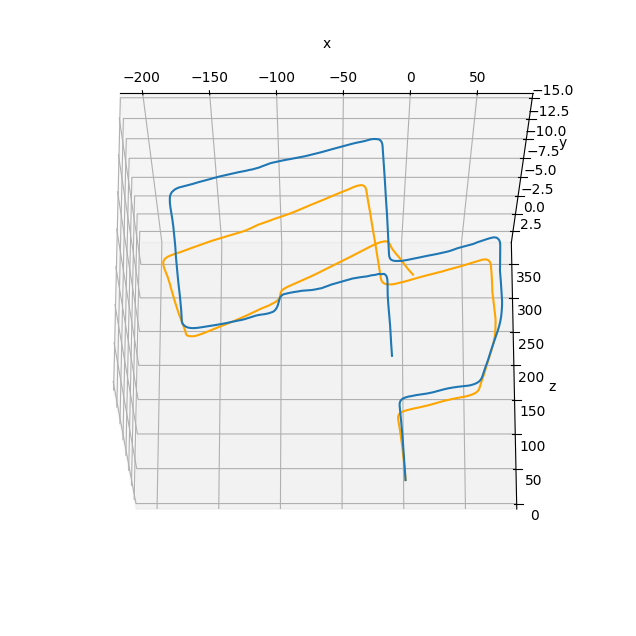

In [76]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(trajectory_nolidar_bm[:, :, 3][:, 0], 
        trajectory_nolidar_bm[:, :, 3][:, 1], 
        trajectory_nolidar_bm[:, :, 3][:, 2], label='estimated', color='orange')

ax.plot(handler.gt[:, :, 3][:, 0], 
        handler.gt[:, :, 3][:, 1], 
        handler.gt[:, :, 3][:, 2], label='ground truth')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.view_init(elev=-20, azim=270)

In [77]:
import numpy as np

# We need a function to tell us how much error we have compared to the ground truth
# We will use Euclidean distance of each camera pose from the ground truth to give us
# Mean Squared Error (mse), Root Mean Squared Error (rmse), or Mean Absolute Error (mae)

def calculate_error(ground_truth, estimated, error_type='mse'):
    '''
    Takes arrays of ground truth and estimated poses of shape Nx3x4, and computes error using
    Euclidean distance between true and estimated 3D translation coordinates at each timestep.
    
    Arguments:
    ground_truth -- Nx3x4 array of ground truth poses
    estimated -- Nx3x4 array of estimated poses
    
    Optional Arguments:
    error_type -- (str) can be 'mae', 'mse', 'rmse', or 'all' to return dictionary of all 3
    
    Returns:
    error -- either a float or dictionary of error types and float values
    '''

    # Ensure both arrays have the same number of frames
    n = min(ground_truth.shape[0], estimated.shape[0])

    # Extract translation components (x, y, z) from both arrays
    gt_xyz = ground_truth[:n, :, 3]
    est_xyz = estimated[:n, :, 3]

    # Compute Euclidean distances at each frame
    distances = np.linalg.norm(gt_xyz - est_xyz, axis=1)

    # Error metrics
    mae = distances.mean()
    mse = np.mean(distances**2)
    rmse = np.sqrt(mse)

    if error_type == 'mae':
        return mae
    elif error_type == 'mse':
        return mse
    elif error_type == 'rmse':
        return rmse
    elif error_type == 'all':
        return {'mae': mae, 'mse': mse, 'rmse': rmse}
    else:
        raise ValueError("error_type must be one of: 'mae', 'mse', 'rmse', or 'all'")


In [80]:
calculate_error(handler.gt, trajectory_nolidar_bm, 'all')

{'mae': np.float64(10.152700292482113),
 'mse': np.float64(146.02973142018504),
 'rmse': np.float64(12.08427620588776)}

We can see that our pose estimate drifts away from the ground truth, but that a lot of the shape is there. Let's compare these results to what we can get if we use lidar with StereoBM.

####StereoSGBM disparity matching.

In [ ]:
# Let's see how we do with no lidar, using the SGBM stereo matcher
handler.lidar = False
start = datetime.datetime.now()
trajectory_nolidar_sgbm = visual_odometry(handler,
                                          filter_match_distance=0.5, 
                                          detector='sift',
                                          #matching='FLANN',
                                          stereo_matcher='sgbm',
                                          mask=mask,     
                                          subset=None)
end = datetime.datetime.now()
print('Time to perform odometry:', end-start)

Generating disparities with StereoSGBM
Detecting features with SIFT and matching with BF
Filtering feature matches at threshold of 0.5*distance
Time to compute frame 1: 0:00:00.150777
Time to compute frame 2: 0:00:00.141527
Time to compute frame 3: 0:00:00.141663
Time to compute frame 4: 0:00:00.157182
Time to compute frame 5: 0:00:00.147595
Time to compute frame 6: 0:00:00.175410
Time to compute frame 7: 0:00:00.146435
Time to compute frame 8: 0:00:00.151434
Time to compute frame 9: 0:00:00.168216
Time to compute frame 10: 0:00:00.163992
Time to compute frame 11: 0:00:00.154427
Time to compute frame 12: 0:00:00.140518
Time to compute frame 13: 0:00:00.140090
Time to compute frame 14: 0:00:00.153012
Time to compute frame 15: 0:00:00.128621
Time to compute frame 16: 0:00:00.131204
Time to compute frame 17: 0:00:00.139333
Time to compute frame 18: 0:00:00.137313
Time to compute frame 19: 0:00:00.146841
Time to compute frame 20: 0:00:00.133480
Time to compute frame 21: 0:00:00.139927
Time

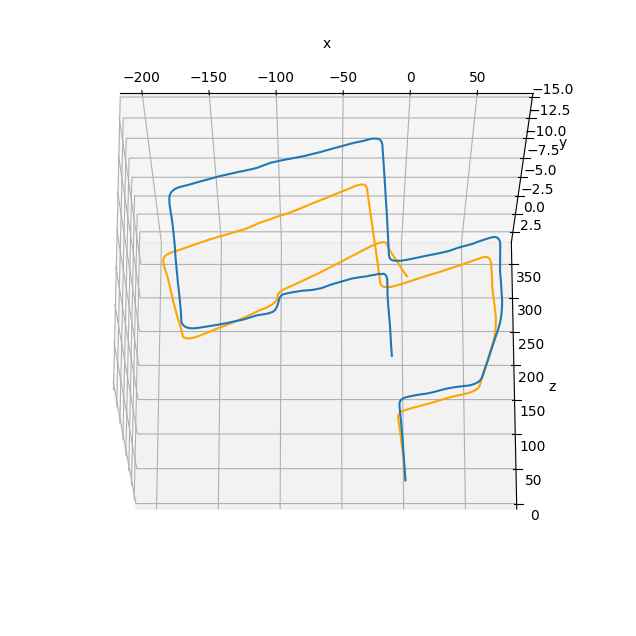

In [82]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(trajectory_nolidar_sgbm[:, :, 3][:, 0], 
        trajectory_nolidar_sgbm[:, :, 3][:, 1], 
        trajectory_nolidar_sgbm[:, :, 3][:, 2], label='estimated', color='orange')

ax.plot(handler.gt[:, :, 3][:, 0], 
        handler.gt[:, :, 3][:, 1], 
        handler.gt[:, :, 3][:, 2], label='ground truth')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.view_init(elev=-20, azim=270)

In [83]:
calculate_error(handler.gt, trajectory_nolidar_sgbm, 'all')

{'mae': np.float64(9.21790492648733),
 'mse': np.float64(116.28147723785425),
 'rmse': np.float64(10.783388949576763)}

We can see that using the StereoSGBM matching for disparity calculation has improved the results significantly, even using no LIDAR correction. Let's see if adding the LIDAR back in and using StereoSGBM can beat these results.

In [87]:
# Let's see if using the FLANN matcher improves our frame rate at all
start = datetime.datetime.now()
trajectory_flann = visual_odometry(handler, 
                                   filter_match_distance=0.5, 
                                   matching='FLANN',
                                   subset=None)
end = datetime.datetime.now()
print('Time to perform odometry:', end-start)

Generating disparities with StereoBM
Detecting features with SIFT and matching with FLANN
Filtering feature matches at threshold of 0.5*distance
Time to compute frame 1: 0:00:00.170433
Time to compute frame 2: 0:00:00.175237
Time to compute frame 3: 0:00:00.169835
Time to compute frame 4: 0:00:00.172020
Time to compute frame 5: 0:00:00.187891
Time to compute frame 6: 0:00:00.183523
Time to compute frame 7: 0:00:00.191170
Time to compute frame 8: 0:00:00.190929
Time to compute frame 9: 0:00:00.183577
Time to compute frame 10: 0:00:00.176009
Time to compute frame 11: 0:00:00.167831
Time to compute frame 12: 0:00:00.171628
Time to compute frame 13: 0:00:00.162280
Time to compute frame 14: 0:00:00.167947
Time to compute frame 15: 0:00:00.156458
Time to compute frame 16: 0:00:00.164115
Time to compute frame 17: 0:00:00.182860
Time to compute frame 18: 0:00:00.191671
Time to compute frame 19: 0:00:00.163714
Time to compute frame 20: 0:00:00.179827
Time to compute frame 21: 0:00:00.169865
Tim

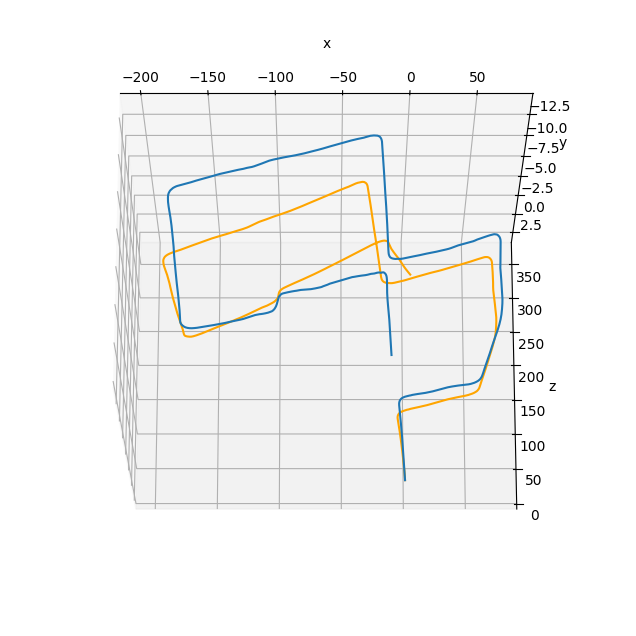

In [93]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(trajectory_flann[:, :, 3][:, 0], 
        trajectory_flann[:, :, 3][:, 1], 
        trajectory_flann[:, :, 3][:, 2], label='estimated', color='orange')

ax.plot(handler.gt[:, :, 3][:, 0], 
        handler.gt[:, :, 3][:, 1], 
        handler.gt[:, :, 3][:, 2], label='ground truth')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.view_init(elev=-20, azim=270)

In [ ]:
# Changing to FLANN does not demonstrate any appreciable speed increase, in fact it seems slower

In [90]:
# Let's see how ORB performs
start = datetime.datetime.now()
trajectory_orb = visual_odometry(handler, 
                                   filter_match_distance=0.5, 
                                   detector='orb',
                                   subset=None)
end = datetime.datetime.now()
print('Time to perform odometry:', end-start)

Generating disparities with StereoBM
Detecting features with ORB and matching with BF
Filtering feature matches at threshold of 0.5*distance
Time to compute frame 1: 0:00:00.036823
Time to compute frame 2: 0:00:00.031283
Time to compute frame 3: 0:00:00.039981
Time to compute frame 4: 0:00:00.036506
Time to compute frame 5: 0:00:00.031339
Time to compute frame 6: 0:00:00.035190
Time to compute frame 7: 0:00:00.033821
Time to compute frame 8: 0:00:00.031993
Time to compute frame 9: 0:00:00.031377
Time to compute frame 10: 0:00:00.037920
Time to compute frame 11: 0:00:00.030457
Time to compute frame 12: 0:00:00.030380
Time to compute frame 13: 0:00:00.035462
Time to compute frame 14: 0:00:00.035187
Time to compute frame 15: 0:00:00.031578
Time to compute frame 16: 0:00:00.040365
Time to compute frame 17: 0:00:00.029980
Time to compute frame 18: 0:00:00.032017
Time to compute frame 19: 0:00:00.030336
Time to compute frame 20: 0:00:00.031353
Time to compute frame 21: 0:00:00.033149
Time to

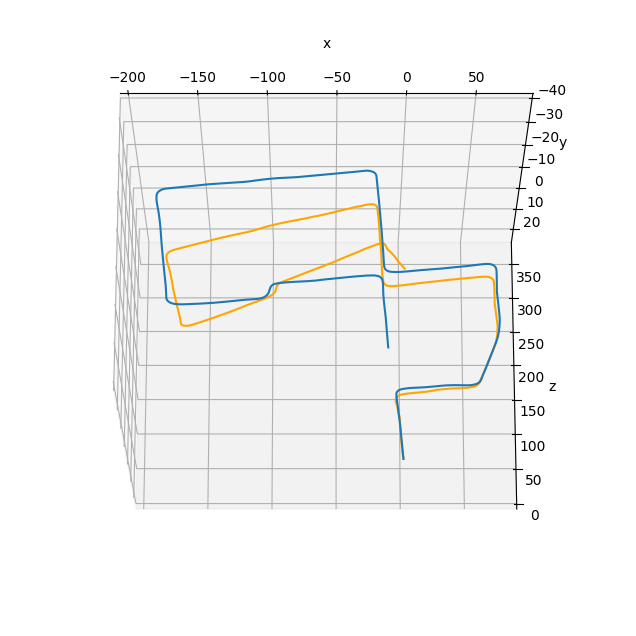

In [94]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(trajectory_orb[:, :, 3][:, 0], 
        trajectory_orb[:, :, 3][:, 1], 
        trajectory_orb[:, :, 3][:, 2], label='estimated', color='orange')

ax.plot(handler.gt[:, :, 3][:, 0], 
        handler.gt[:, :, 3][:, 1], 
        handler.gt[:, :, 3][:, 2], label='ground truth')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.view_init(elev=-20, azim=270)

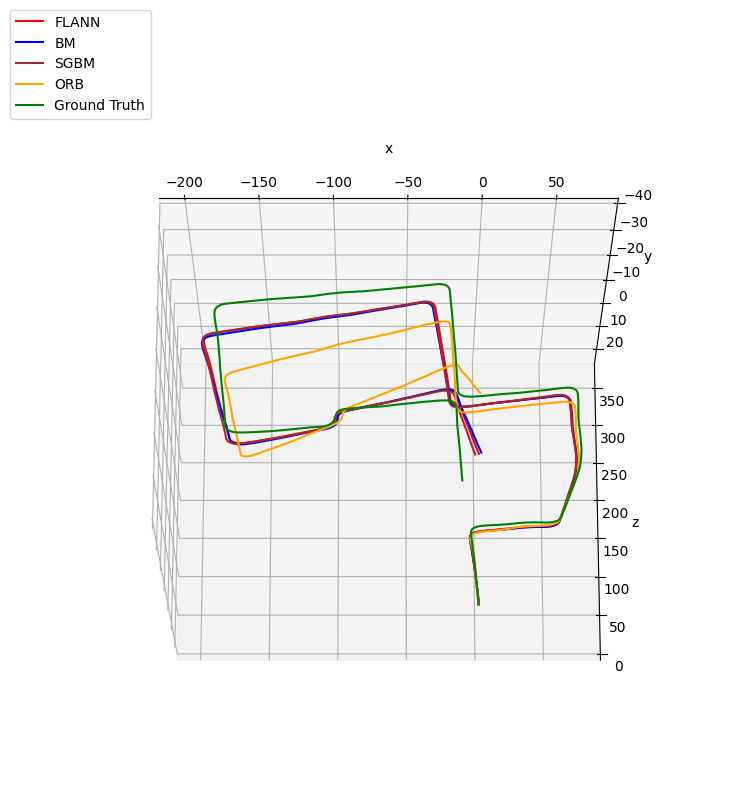

In [101]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot all trajectories with descriptive labels
ax.plot(trajectory_flann[:, :, 3][:, 0], 
        trajectory_flann[:, :, 3][:, 1], 
        trajectory_flann[:, :, 3][:, 2], label='FLANN', color='red')

ax.plot(trajectory_nolidar_bm[:, :, 3][:, 0], 
        trajectory_nolidar_bm[:, :, 3][:, 1], 
        trajectory_nolidar_bm[:, :, 3][:, 2], label='BM', color='blue')

ax.plot(trajectory_nolidar_sgbm[:, :, 3][:, 0], 
        trajectory_nolidar_sgbm[:, :, 3][:, 1], 
        trajectory_nolidar_sgbm[:, :, 3][:, 2], label='SGBM', color='brown')

ax.plot(trajectory_orb[:, :, 3][:, 0], 
        trajectory_orb[:, :, 3][:, 1], 
        trajectory_orb[:, :, 3][:, 2], label='ORB', color='orange')

ax.plot(handler.gt[:, :, 3][:, 0], 
        handler.gt[:, :, 3][:, 1], 
        handler.gt[:, :, 3][:, 2], label='Ground Truth', color='green')

# Axis labels
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

# Camera view angle
ax.view_init(elev=-20, azim=270)

# Display the legend in the top-left corner (outside the plot)
ax.legend(loc='upper left', bbox_to_anchor=(-0.05, 1.15))

plt.tight_layout()
plt.show()


# Appendix A:
Showing that arithmetic strategy faster than dot product:

In [ ]:
# Decompose projection matrix to get intrinsic k matrix
k0, r0, t0, _, _, _, _ = cv2.decomposeProjectionMatrix(handler.P0)

In [ ]:
# First run the math using the arithmetric derived from what the matrix multiplication does
start = datetime.datetime.now()
cx = k0[0, 2]
cy = k0[1, 2]
fx = k0[0, 0]
fy = k0[1, 1]
delete = []
object_points = np.zeros((0, 3))
image1_points = np.float32([kp0[m.queryIdx].pt for m in matches])
for i, (u, v) in enumerate(image1_points):
    z = depth[int(v), int(u)]
    if z > 3000:
        delete.append(i)
        continue
    x = z*(u-cx)/fx
    y = z*(v-cy)/fy
    object_points = np.vstack([object_points, np.array([x, y, z])])
    #object_points = np.vstack([object_points, np.linalg.inv(k0).dot(z*np.array([u, v, 1]))])
end = datetime.datetime.now()
print('Time to compute:', end-start)
print(object_points)

Time to compute: 0:00:00.037968
[[  3.50461848  -2.25380255  48.2681    ]
 [ -5.9355166   -4.52124313  29.70344615]
 [-13.00586866  -1.1806672   31.52202449]
 ...
 [ -1.86770698   0.60537074  25.32097049]
 [ -0.20512125   1.47857621  16.08936667]
 [  1.56142055   1.54149227  15.33081092]]


In [ ]:
# Now run the math using matrix multiplication with the inverted k matrix
start = datetime.datetime.now()
delete = []
object_points = np.zeros((0, 3))
image1_points = np.float32([kp0[m.queryIdx].pt for m in matches])
for i, (u, v) in enumerate(image1_points):
    z = depth[int(v), int(u)]
    if z > 3000:
    #    print(z)
        delete.append(i)
        continue
    #else:
    #    print(u,v)
    x = z*(u-cx)/fx
    y = z*(v-cy)/fy
    #object_points = np.vstack([object_points, np.array([x, y, z])])
    object_points = np.vstack([object_points, np.linalg.inv(k0).dot(z*np.array([u, v, 1]))])
end = datetime.datetime.now()
print('Time to compute:', end-start)
print(object_points)

Time to compute: 0:00:00.069964
[[  3.50461848  -2.25380255  48.2681    ]
 [ -5.9355166   -4.52124313  29.70344615]
 [-13.00586866  -1.1806672   31.52202449]
 ...
 [ -1.86770698   0.60537074  25.32097049]
 [ -0.20512125   1.47857621  16.08936667]
 [  1.56142055   1.54149227  15.33081092]]


In [ ]:
# We can see that the arithmetic method is significantly faster